In [24]:
# =============================================================================
# IMPORT STATEMENTS - ORGANIZED BY CATEGORY
# =============================================================================

# System and Path Management
import sys
import os
import warnings
import random

# Add custom particles-cdssm path
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))

# Data Analysis and Numerical Computing
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import acf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Financial Data
import yfinance as yf

# JAX and NumPyro (HMC/NUTS)
import jax
import jax.numpy as jnp
import jax.lax as lax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

# Particles Package
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments
from particles.state_space_models import StochVol, Bootstrap

# Custom Particles CDSSM Collectors
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD

# Configuration
warnings.filterwarnings('ignore')

# Data and visualisation

In [25]:
def fetch_sp500_data(start_date="2010-01-01", end_date="2025-11-01"):
    # Download S&P 500 data
    ticker = "^GSPC"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Calculate log returns (skip first day as we need previous close)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    data = data.dropna() #! remove any potential na's
    
    print(f"Downloaded {len(data)} trading days")
    print(f"Some basic stats: Mean={data['Returns'].mean():.3f}%, Std={data['Returns'].std():.2f}%")
    
    return data

# Fetch the data
data = fetch_sp500_data()
data.head()

Downloaded 3916 trading days
Some basic stats: Mean=0.044%, Std=1.10%


Price,Close,High,Low,Open,Volume,Returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.311083
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.054537
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.399322
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.287758
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.174523


In [2]:
def fetch_sp500_data(start_date="2010-01-01", end_date="2025-11-01"):
    # Download S&P 500 data
    ticker = "^GSPC"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Calculate log returns (skip first day as we need previous close)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    data = data.dropna() #! remove any potential na's
    
    print(f"Downloaded {len(data)} trading days")
    print(f"Some basic stats: Mean={data['Returns'].mean():.3f}%, Std={data['Returns'].std():.2f}%")
    
    return data

# Fetch the data
data = fetch_sp500_data()


#! Train and test data split
# Function to split data into training and testing sets

def split_data(data, train_ratio=0.8):
    """Split data into training and testing sets"""
    n_total = len(data)
    n_train = int(n_total * train_ratio)
    
    train_data = data.iloc[:n_train].copy()
    test_data = data.iloc[n_train:].copy()
    
    print(f"Data split:")
    print(f"  Training: {len(train_data)} days ({train_data.index[0]} to {train_data.index[-1]})")
    print(f"  Testing:  {len(test_data)} days ({test_data.index[0]} to {test_data.index[-1]})")
    
    return train_data, test_data

# Split the data
train_data, test_data = split_data(data, train_ratio=0.8)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

Downloaded 3916 trading days
Some basic stats: Mean=0.044%, Std=1.10%
Data split:
  Training: 3132 days (2010-01-05 00:00:00 to 2022-06-13 00:00:00)
  Testing:  784 days (2022-06-14 00:00:00 to 2025-07-30 00:00:00)


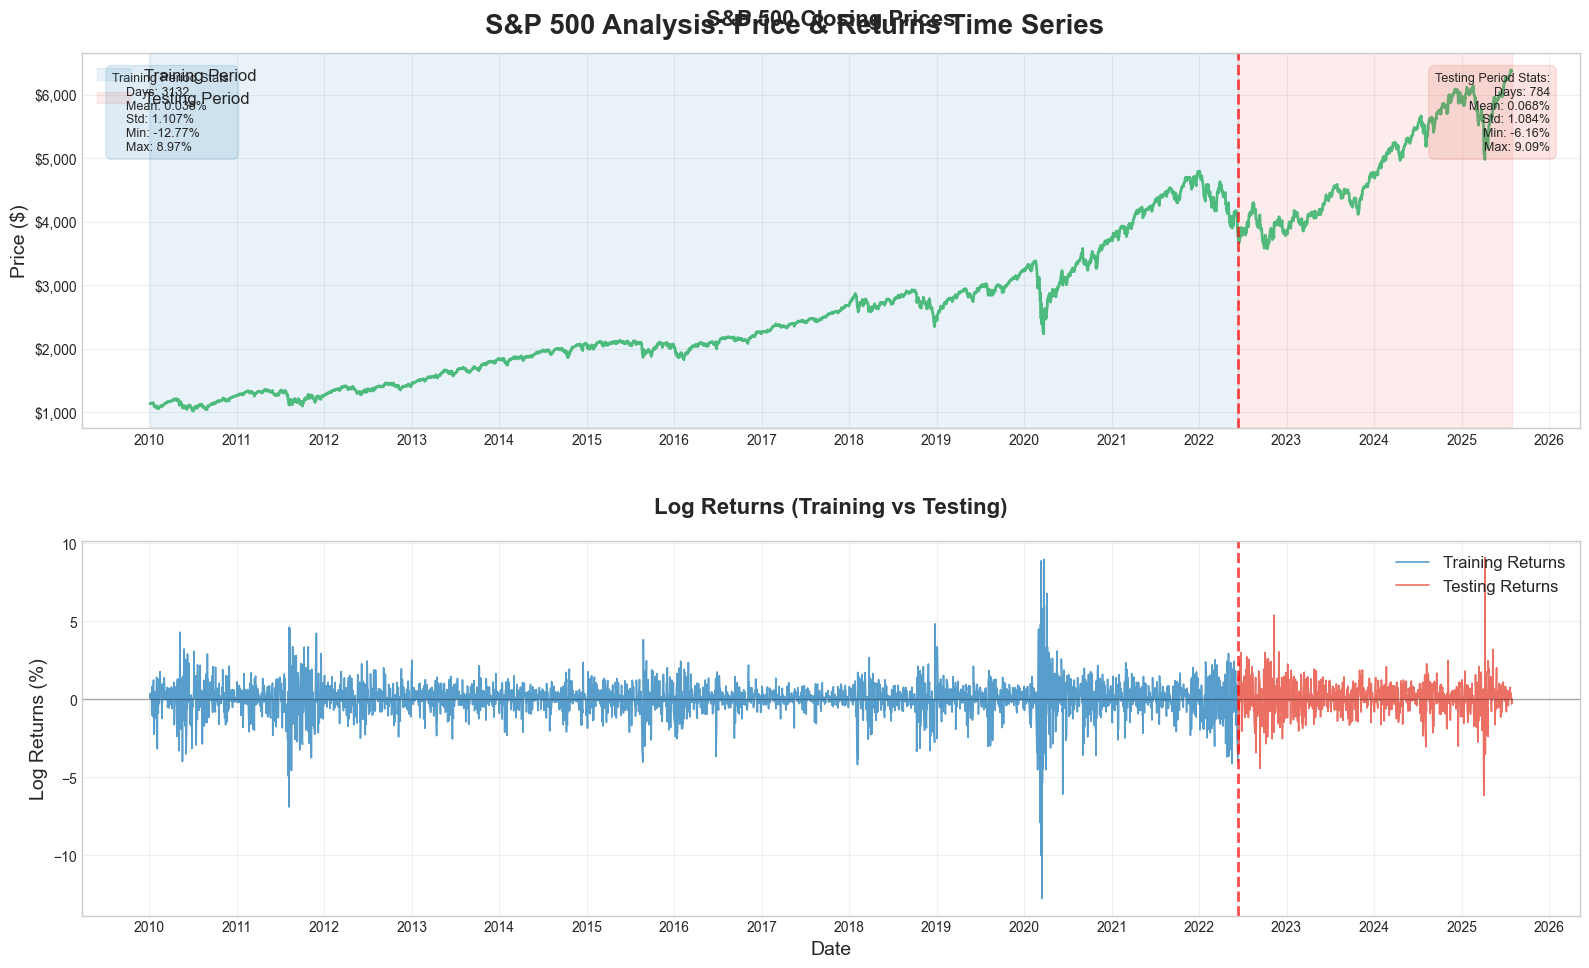


📊 S&P 500 DATA SUMMARY
Total Period: 2010-01-05 to 2025-07-30
Total Trading Days: 3916
Training Split: 3132 days (80.0%)
Testing Split: 784 days (20.0%)

Volatility Clustering Analysis:
Training Period Volatility: 1.107%
Testing Period Volatility: 1.084%

Extreme Days (|returns| > 2%):
Training: 191 days (6.1%)
Testing: 45 days (5.7%)


In [3]:
def plot_sp500_timeseries(data, train_data, test_data):
    """
    Create a beautiful time series visualization of S&P 500 data
    """
    # Set style for beautiful plots
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('S&P 500 Analysis: Price & Returns Time Series', 
                 fontsize=20, fontweight='bold', y=0.96)
    
    # Color scheme
    train_color = '#2E86C1'  # Blue
    test_color = '#E74C3C'   # Red
    price_color = '#27AE60'  # Green
    
    # Plot 1: S&P 500 Price with Train/Test Split
    axes[0].plot(data.index, data['Close'], color=price_color, linewidth=2, alpha=0.8)
    
    # Add vertical line to show train/test split
    split_date = test_data.index[0]
    axes[0].axvline(x=split_date, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Shade train and test regions
    axes[0].axvspan(train_data.index[0], train_data.index[-1], 
                   alpha=0.1, color=train_color, label='Training Period')
    axes[0].axvspan(test_data.index[0], test_data.index[-1], 
                   alpha=0.1, color=test_color, label='Testing Period')
    
    axes[0].set_title('S&P 500 Closing Prices', fontsize=16, fontweight='bold', pad=20)
    axes[0].set_ylabel('Price ($)', fontsize=14)
    axes[0].legend(loc='upper left', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Format y-axis for price
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Plot 2: Log Returns - Full Series
    axes[1].plot(train_data.index, train_data['Returns'], 
                color=train_color, linewidth=1.2, alpha=0.8, label='Training Returns')
    axes[1].plot(test_data.index, test_data['Returns'], 
                color=test_color, linewidth=1.2, alpha=0.8, label='Testing Returns')
    
    # Add zero line
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # Add vertical line for split
    axes[1].axvline(x=split_date, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    axes[1].set_title('Log Returns (Training vs Testing)', fontsize=16, fontweight='bold', pad=20)
    axes[1].set_ylabel('Log Returns (%)', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=14)
    axes[1].legend(loc='upper right', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Format x-axis for all subplots
    for ax in axes:
        ax.tick_params(axis='x', rotation=0, labelsize=10)  # Remove rotation for cleaner look
        ax.tick_params(axis='y', labelsize=10)
        # Improve date formatting
        ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator((1, 7)))  # Jan and July
    
    # Add summary statistics text box
    train_stats = f"""Training Period Stats:
    Days: {len(train_data)}
    Mean: {train_data['Returns'].mean():.3f}%
    Std: {train_data['Returns'].std():.3f}%
    Min: {train_data['Returns'].min():.2f}%
    Max: {train_data['Returns'].max():.2f}%"""
    
    test_stats = f"""Testing Period Stats:
    Days: {len(test_data)}
    Mean: {test_data['Returns'].mean():.3f}%
    Std: {test_data['Returns'].std():.3f}%
    Min: {test_data['Returns'].min():.2f}%
    Max: {test_data['Returns'].max():.2f}%"""
    
    # Add text boxes with statistics
    axes[0].text(0.02, 0.95, train_stats, transform=axes[0].transAxes, 
                fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                facecolor=train_color, alpha=0.15, edgecolor=train_color))
    
    axes[0].text(0.98, 0.95, test_stats, transform=axes[0].transAxes, 
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=test_color, alpha=0.15, edgecolor=test_color))
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("📊 S&P 500 DATA SUMMARY")
    print("="*60)
    print(f"Total Period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Trading Days: {len(data)}")
    print(f"Training Split: {len(train_data)} days ({len(train_data)/len(data):.1%})")
    print(f"Testing Split: {len(test_data)} days ({len(test_data)/len(data):.1%})")
    print("\nVolatility Clustering Analysis:")
    print(f"Training Period Volatility: {train_data['Returns'].std():.3f}%")
    print(f"Testing Period Volatility: {test_data['Returns'].std():.3f}%")
    
    # Calculate some interesting metrics
    train_extreme_days = len(train_data[abs(train_data['Returns']) > 2])
    test_extreme_days = len(test_data[abs(test_data['Returns']) > 2])
    print(f"\nExtreme Days (|returns| > 2%):")
    print(f"Training: {train_extreme_days} days ({train_extreme_days/len(train_data):.1%})")
    print(f"Testing: {test_extreme_days} days ({test_extreme_days/len(test_data):.1%})")

# Usage
plot_sp500_timeseries(data, train_data, test_data)

# Model Definitions

In [4]:
class StochasticVolatilityModel(ssm.StateSpaceModel):
    """
    Stochastic Volatility Model with logit-transformed φ parameter
    Parameters (μ, logit_phi, σ^2):
    - mu: long-run log-volatility level
    - logit_phi: logit-transformed persistence parameter
    - sigma_x: volatility of log-volatility
    
    Note: phi = exp(logit_phi) / (1 + exp(logit_phi))
    """
    
    def __init__(self, mu=-2.5, logit_phi=2.94, sigma_x=0.3):
        self.mu = mu
        self.logit_phi = logit_phi
        self.sigma_x = sigma_x
        
        # Convert logit_phi back to phi for internal calculations
        self.phi = np.exp(logit_phi) / (1 + np.exp(logit_phi))
        
    def PX0(self):
        """Initial distribution of log-volatility"""
        # Stationary distribution: X_0 ~ N(mu, sigma_x^2 / (1 - phi^2))
        var_stat = self.sigma_x**2 / (1 - self.phi**2)
        return particles.distributions.Normal(loc=self.mu, scale=np.sqrt(var_stat))
    
    def PX(self, t, xp):
        # State transition: X_t | X_{t-1}
        # X_{t-1} = xp
        mean = self.mu + self.phi * (xp - self.mu)
        return particles.distributions.Normal(loc=mean, scale=self.sigma_x)
    
    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        # Y_t = exp(X_t/2) * eta_t where eta_t ~ N(0,1)
        x_bounded = np.clip(x, -15, 5)  # Clip to avoid extreme values
        volatility = np.exp(x_bounded / 2)
        volatility = np.maximum(volatility, 1e-6)  # Avoid zero volatility
        return particles.distributions.Normal(loc=0.0, scale=volatility)

class BlackScholesModel(ssm.StateSpaceModel):
    """
    Simple constant volatility model (Black-Scholes baseline)
    Just returns constant normal distribution - no real dynamics
    """
    def __init__(self, volatility):
        self.volatility = volatility
    
    def PX0(self):
        """Dummy initial state - not really used"""
        return particles.distributions.Normal(loc=0, scale=0.001)
    
    def PX(self, t, xp):
        """Dummy state transition - essentially no change"""
        return particles.distributions.Normal(loc=xp, scale=0.0001)
    
    def PY(self, t, xp, x):
        """Observation model: Y_t ~ N(0, σ²) with constant σ"""
        N = len(x) if hasattr(x, '__len__') else 1
        return particles.distributions.Normal(
            loc=np.zeros(N), 
            scale=self.volatility
        )



## Filtering and smoothing

In [5]:
def run_particle_filter(model, returns, N=1000):
    """
    Run particle filter for stochastic volatility estimation
    """
    # Convert returns to numpy array
    y_data = returns.values
    T = len(y_data)
    
    # Create bootstrap filter
    fk_model = ssm.Bootstrap(ssm=model, data=y_data)
    
    # Run the algorithm
    pf = particles.SMC(fk=fk_model, N=N, collect=[Moments()])
    pf.run()
    
    # Filtering means and variances
    filtering_means = np.array([pf.summaries.moments[t]['mean'] for t in range(T)])
    filtering_vars = np.array([pf.summaries.moments[t]['var'] for t in range(T)])
    
    # Convert log-volatility to volatility percentage
    vol_estimates = np.exp(filtering_means / 2) * np.sqrt(252)  # Annualized volatility
    vol_std = np.sqrt(filtering_vars) * np.exp(filtering_means / 2) * np.sqrt(252)

    return {
        'log_vol_mean': filtering_means,
        'log_vol_var': filtering_vars,
        'vol_estimates': vol_estimates,
        'vol_std': vol_std,
        'particle_filter': pf
    }
def run_particle_smoother(model, returns, N=1000):
    """
    Simple particle smoother for volatility estimation
    """
    # Convert returns to numpy array
    y_data = returns.values
    T = len(y_data)
    
    # Run forward filter with history storage
    fk = ssm.Bootstrap(ssm=model, data=y_data)
    pf = particles.SMC(fk=fk, N=N, store_history=True)
    pf.run()
    
    # Try backward sampling for proper smoothing
    try:
        M = N // 10  # Number of backward trajectories
        paths = particles.backward_sampling(pf, M=M)
        
        # Get smoothed estimates from trajectories
        if paths.shape[0] == T:  # T x M shape
            smoothed_means = np.mean(paths, axis=1)
            smoothed_vars = np.var(paths, axis=1)
        else:  # M x T shape
            smoothed_means = np.mean(paths, axis=0)
            smoothed_vars = np.var(paths, axis=0)
            
    except:
        # Fallback: use filtering estimates with simple smoothing
        pf_filter = particles.SMC(fk=fk, N=N, collect=[Moments()])
        pf_filter.run()
        
        filtering_means = np.array([pf_filter.summaries.moments[t]['mean'] for t in range(T)])
        filtering_vars = np.array([pf_filter.summaries.moments[t]['var'] for t in range(T)])
        
        # Simple moving average smoothing (window=10)
        window = 10
        smoothed_means = np.convolve(filtering_means, np.ones(window)/window, mode='same')
        smoothed_vars = np.convolve(filtering_vars, np.ones(window)/window, mode='same')
    
    # Convert to annualized volatility percentage
    vol_estimates = np.exp(smoothed_means / 2) * np.sqrt(252)
    vol_std = np.sqrt(smoothed_vars) * np.exp(smoothed_means / 2) * np.sqrt(252)
    
    return {
        'log_vol_mean': smoothed_means,
        'log_vol_var': smoothed_vars,
        'vol_estimates': vol_estimates,
        'vol_std': vol_std
    }

## Estimation diagnostics

In [6]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    
    
    fig, axes = plt.subplots(1, len(param_names), figsize=(15, 4))
    if len(param_names) == 1:
        axes = [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)  # Don't use too many lags
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))  # Ensure ESS is at least 1
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)  # Conservative estimate
    
    return np.array(ess_values)

def mcmc_diagnostics(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics"""
    print("\n📊 MCMC Convergence Diagnostics:")
    print("=" * 40)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    for i, param in enumerate(param_names):
        print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and ACF
    fig, axes = plt.subplots(2, n_params, figsize=(15, 8))
    if n_params == 1:
        axes = axes.reshape(-1, 1)
    
    for i, param in enumerate(param_names):
        # Trace plot
        axes[0, i].plot(chain[:, i], alpha=0.7)
        axes[0, i].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                          label='Burn-in end')
        axes[0, i].set_title(f'Trace: {param}')
        axes[0, i].set_ylabel('Value')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].legend()
        
        # Density plot
        axes[1, i].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[1, i].set_title(f'Posterior: {param}')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Density')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    return ess


## Parameter Estimation hmc

In [7]:
def bayesian_parameter_estimation_numpyro(returns, n_warmup=1000, n_samples=2000, n_chains=4, n_burn=500):
    """
    Bayesian parameter estimation for SV model using NumPyro with NUTS (HMC variant).
    Uses non-centered reparameterization for better mixing.
    """

    import jax
    from jax import random
    import jax.numpy as jnp
    import numpyro
    import numpyro.distributions as dist
    from numpyro.infer import MCMC, NUTS
    from numpyro.diagnostics import effective_sample_size as numpyro_ess
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import acf
    print(f"🎯 Running NumPyro NUTS estimation ({n_chains} chains, {n_warmup} warmup, {n_samples} samples)...")
    
    # Convert returns to numpy array first (fix for pandas Series)
    returns_np = returns.values.astype(np.float32)  # Use float32 for efficiency
    
    # Empirical mu for prior centering (adjustment for log-returns in decimal)
    emp_mu = np.mean(np.log(returns_np**2 + 1e-16)) + 1.2704  # Bias correction
    print(f"Empirical mu estimate: {emp_mu:.2f}")
    
    # Convert to JAX array
    returns_jax = jnp.array(returns_np)
    
    def sv_model(returns):
        mu = numpyro.sample('mu', dist.Normal(loc=emp_mu, scale=2.0))
        
        # Logit reparam for phi in (0,1)
        logit_phi = numpyro.sample('logit_phi', dist.Normal(loc=2.94, scale=1.0))
        phi = numpyro.deterministic('phi', jnp.exp(logit_phi) / (1 + jnp.exp(logit_phi)))
        
        sigma_x = numpyro.sample('sigma_x', dist.InverseGamma(3, 0.5))
        
        T = returns.shape[0]
        
        # Non-centered: sample i.i.d innovations
        eta = numpyro.sample('eta', dist.Normal(0, 1), sample_shape=(T,))
        
        # Deterministically build h (log-vol) using scan for efficiency
        def build_h(carry, xs):
            t, eta_t = xs
            h_t = mu + phi * (carry - mu) + sigma_x * eta_t
            return h_t, h_t
        
        # Initial h_0 from stationary dist
        h_init = mu + (sigma_x / jnp.sqrt(1 - phi**2 + 1e-10)) * eta[0]  # Avoid div by zero
        
        # Scan over t=1 to T-1
        _, h_rest = jax.lax.scan(build_h, h_init, (jnp.arange(1, T), eta[1:]))
        h = jnp.concatenate([h_init[None], h_rest])
        
        numpyro.deterministic('h', h)
        
        # Observations (decimal returns)
        numpyro.sample('obs', dist.Normal(0.0, jnp.exp(h / 2)), obs=returns)
    
    # Set up NUTS sampler
    nuts_kernel = NUTS(sv_model)
    mcmc = MCMC(nuts_kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, progress_bar=True)
    
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, returns=returns_jax)
    
    # Get samples (dict with 'mu', 'logit_phi', 'sigma_x', etc.; phi is deterministic)
    samples = mcmc.get_samples()
    
    # Compute phi samples from logit_phi
    phi_samples = jnp.exp(samples['logit_phi']) / (1 + jnp.exp(samples['logit_phi']))
    
    # Handle single vs multi-chain shaping
    is_single_chain = (samples['mu'].ndim == 1)
    if is_single_chain:
        burned_mu = samples['mu'][n_burn:]
        burned_phi = phi_samples[n_burn:]
        burned_sigma_x = samples['sigma_x'][n_burn:]
        # Reshape to (1, -1) for consistency in ESS etc.
        burned_mu = burned_mu[None, :]
        burned_phi = burned_phi[None, :]
        burned_sigma_x = burned_sigma_x[None, :]
    else:
        burned_mu = samples['mu'][:, n_burn:]
        burned_phi = phi_samples[:, n_burn:]
        burned_sigma_x = samples['sigma_x'][:, n_burn:]
    
    burned_samples = {
        'mu': burned_mu,
        'phi': burned_phi,
        'sigma_x': burned_sigma_x
    }
    
    # Chain for output (flatten chains)
    burned_chain = jnp.stack([burned_mu, burned_phi, burned_sigma_x], axis=-1).reshape(-1, 3)
    
    param_names = ['mu', 'phi', 'sigma_x']
    
    # Diagnostics: ESS on burned samples (expects shape (chains, samples))
    ess = {p: numpyro_ess(burned_samples[p]) for p in param_names}
    ess_values = [ess[p] for p in param_names]
    print("\n📊 MCMC Convergence Diagnostics:")
    print(f"Effective Sample Sizes: {ess}")
    
    # Traces and ACF use full samples (adjust for single chain)
    if is_single_chain:
        mu_full = samples['mu'][None, :]
        phi_full = phi_samples[None, :]
        sigma_x_full = samples['sigma_x'][None, :]
    else:
        mu_full = samples['mu']
        phi_full = phi_samples
        sigma_x_full = samples['sigma_x']
    
    full_samples_for_plot = {
        'mu': mu_full,
        'phi': phi_full,
        'sigma_x': sigma_x_full
    }
    
    for i, param in enumerate(param_names):
        param_samples = full_samples_for_plot[param]
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(param_samples.T, alpha=0.5)
        plt.title(f'Trace: {param}')
        plt.axvline(n_burn, color='r', linestyle='--')
        
        plt.subplot(1, 2, 2)
        lags = np.arange(50)
        autocorr = acf(param_samples.mean(axis=0), nlags=49)  # Avg over chains
        plt.plot(lags, autocorr)
        plt.axhline(0.05, color='r', linestyle='--')
        plt.axhline(-0.05, color='r', linestyle='--')
        plt.title(f'ACF: {param}')
        plt.show()
    
    # Parameter estimates from burned_chain
    param_estimates = {
        param: {'mean': jnp.mean(burned_chain[:, i]), 'std': jnp.std(burned_chain[:, i])}
        for i, param in enumerate(param_names)
    }
    
    # Also store logit_phi
    if is_single_chain:
        logit_phi_burned = samples['logit_phi'][n_burn:]
    else:
        logit_phi_burned = samples['logit_phi'][:, n_burn:].reshape(-1)
    logit_phi_estimates = {
        'mean': jnp.mean(logit_phi_burned),
        'std': jnp.std(logit_phi_burned)
    }
    
    return {
        'chain': jnp.stack([burned_mu, burned_phi, burned_sigma_x], axis=-1),
        'burned_chain': burned_chain,
        'estimates': param_estimates,
        'logit_phi_estimates': logit_phi_estimates,
        'effective_sample_size': ess_values,
        'param_names': param_names,
        'mcmc': mcmc  # For further inspection
    }

## Execution script

📊 Step 1: Loading and preprocessing S&P 500 data...
Downloaded 1257 trading days
Some basic stats: Mean=0.047%, Std=1.35%
Data split:
  Training: 1005 days (2020-01-03 00:00:00 to 2023-12-29 00:00:00)
  Testing:  252 days (2024-01-02 00:00:00 to 2024-12-31 00:00:00)
✓ Data preprocessing completed

🎯 Step 2: Running particle filtering and smoothing...
✓ Filtering and smoothing completed

⛓️  Step 3: Running Bayesian parameter estimation with NUTS...
🎯 Running NumPyro NUTS estimation (4 chains, 5000 warmup, 20000 samples)...
Empirical mu estimate: -9.14
✓ Filtering and smoothing completed

⛓️  Step 3: Running Bayesian parameter estimation with NUTS...
🎯 Running NumPyro NUTS estimation (4 chains, 5000 warmup, 20000 samples)...
Empirical mu estimate: -9.14


sample: 100%|██████████| 25000/25000 [00:35<00:00, 698.33it/s, 31 steps of size 1.01e-01. acc. prob=0.85] 

sample: 100%|██████████| 25000/25000 [00:40<00:00, 622.18it/s, 63 steps of size 7.47e-02. acc. prob=0.92]

sample: 100%|██████████| 25000/25000 [00:39<00:00, 633.48it/s, 63 steps of size 9.71e-02. acc. prob=0.85] 




📊 MCMC Convergence Diagnostics:
Effective Sample Sizes: {'mu': 12471.110102245952, 'phi': 10502.103598727339, 'sigma_x': 29884.631567588032}


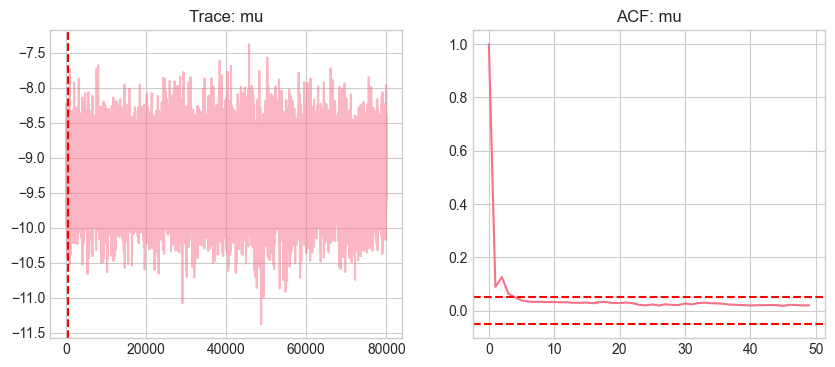

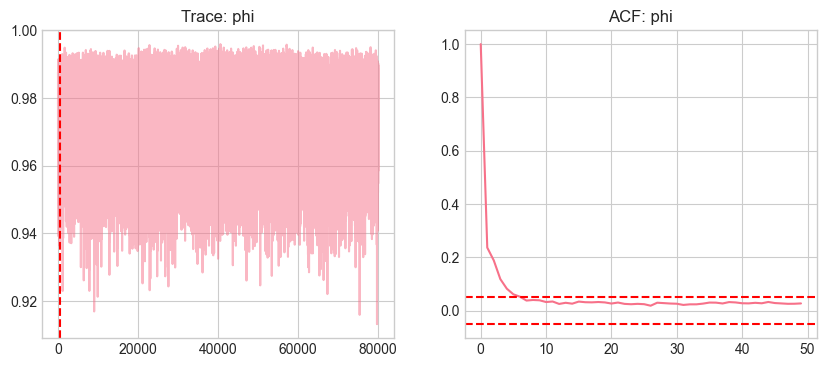

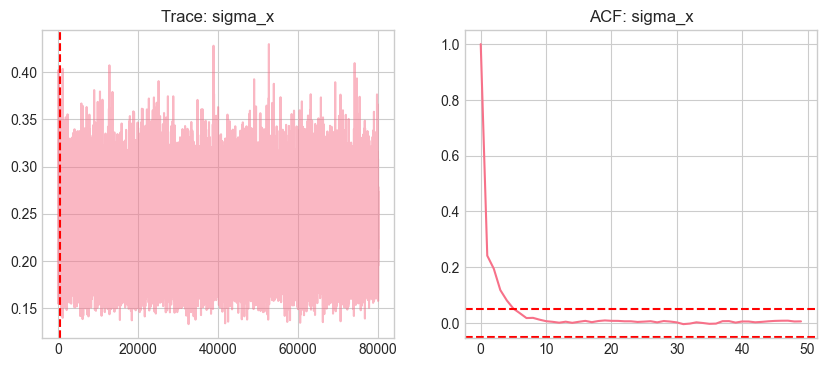

✓ MCMC parameter estimation completed


In [8]:
# =============================================================================
# MAIN EXECUTION SCRIPT
# =============================================================================

# Step 1: Data Loading and Preprocessing
print("📊 Step 1: Loading and preprocessing S&P 500 data...")
data = fetch_sp500_data(start_date="2020-01-01", end_date="2025-01-01")
train_data, test_data = split_data(data, train_ratio=0.8)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

# Convert percentage returns to decimal returns for modeling
train_data_decimal = train_data.copy()
train_data_decimal['Returns'] = returns_train / 100
returns_train_decimal = returns_train / 100

test_data_decimal = test_data.copy()
test_data_decimal['Returns'] = returns_test / 100
returns_test_decimal = returns_test / 100

print("✓ Data preprocessing completed")

# Step 2: Model Setup and Filtering
print("\n🎯 Step 2: Running particle filtering and smoothing...")
model = StochasticVolatilityModel()
filtering_results = run_particle_filter(model, returns_train, N=1000)
smoothing_results = run_particle_smoother(model, returns_train, N=1000)
print("✓ Filtering and smoothing completed")

# Step 3: Bayesian Parameter Estimation with HMC
print("\n⛓️  Step 3: Running Bayesian parameter estimation with NUTS...")
mcmc_results = bayesian_parameter_estimation_numpyro(
    returns_train_decimal, 
    n_warmup=5000, 
    n_samples=20000
)
print("✓ MCMC parameter estimation completed")

In [18]:
# =============================================================================
# HELPER FUNCTIONS FOR PARAMETER TRANSFORMATIONS
# =============================================================================

def phi_to_logit_phi(phi):
    """
    Convert phi to logit_phi transformation
    
    Parameters:
    -----------
    phi : float or array
        Persistence parameter in (0, 1)
        
    Returns:
    --------
    logit_phi : float or array
        Logit-transformed phi parameter
    """
    return np.log(phi / (1 - phi))

def logit_phi_to_phi(logit_phi):
    """
    Convert logit_phi to phi transformation
    
    Parameters:
    -----------
    logit_phi : float or array
        Logit-transformed phi parameter
        
    Returns:
    --------
    phi : float or array
        Persistence parameter in (0, 1)
    """
    return np.exp(logit_phi) / (1 + np.exp(logit_phi))

def get_logit_phi_prior_params(target_phi_mean=0.95, target_phi_std=0.02):
    """
    Helper to set reasonable prior for logit_phi based on desired phi distribution
    
    Parameters:
    -----------
    target_phi_mean : float, default=0.95
        Target mean for phi distribution
    target_phi_std : float, default=0.02
        Target standard deviation for phi distribution
        
    Returns:
    --------
    target_logit_mean : float
        Suggested logit_phi mean for prior
    """
    target_logit_mean = phi_to_logit_phi(target_phi_mean)
    
    print(f"For phi ~ N({target_phi_mean}, {target_phi_std}²):")
    print(f"  Suggested logit_phi ~ N({target_logit_mean:.2f}, 1.0)")
    print(f"  This gives phi range roughly [{target_phi_mean-2*target_phi_std:.3f}, {target_phi_mean+2*target_phi_std:.3f}]")
    
    return target_logit_mean

# =============================================================================
# ONLINE PREDICTION FUNCTIONS
# =============================================================================

def run_online_predictions(train_data, test_data, mcmc_results, N=1000, K=1):
    """
    Run online adaptive predictions using particle filter with predictive collectors
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training data with 'Returns' column
    test_data : pd.DataFrame
        Test data with 'Returns' column
    mcmc_results : dict
        Results from MCMC parameter estimation
    N : int, default=1000
        Number of particles
    K : int, default=1
        Number of steps ahead to predict (1 for next-day volatility)
        
    Returns:
    --------
    dict : Dictionary containing online prediction results
    """
    print(f"🎯 Running online adaptive predictions with {N} particles, {K}-step ahead...")
    
    # Get estimated parameters from MCMC
    mu_est = mcmc_results['estimates']['mu']['mean']
    phi_est = mcmc_results['estimates']['phi']['mean']  # This is already phi, not logit_phi
    sigma_x_est = mcmc_results['estimates']['sigma_x']['mean']
    
    print(f"Using parameters: μ={mu_est:.3f}, φ={phi_est:.3f}, σ_x={sigma_x_est:.3f}")
    
    # Combine training and test data for online learning
    all_returns = pd.concat([train_data['Returns'], test_data['Returns']])
    y_data = all_returns.values
    n_train = len(train_data)
    n_total = len(all_returns)
    
    print(f"Total data points: {n_total} (train: {n_train}, test: {n_total - n_train})")
    
    # Create SV model with estimated parameters
    # Note: We need to convert back to logit_phi for the model
    logit_phi_est = phi_to_logit_phi(phi_est)
    ssm = StochasticVolatilityModel(mu=mu_est, logit_phi=logit_phi_est, sigma_x=sigma_x_est)
    
    # Create bootstrap Feynman-Kac model
    fk = Bootstrap(ssm=ssm, data=y_data)    
    
    # Define collectors for different types of predictions
    collectors = [
        ObservationPredictiveParticles(K=K),  # Full particle distributions
        ObservationPredictiveMoments(K=K),    # Just means and variances
        NLPD(K=K)                             # Negative log predictive density
    ]
    
    # Run SMC with predictive collectors
    print("🚀 Starting online SMC with predictive collectors...")
    smc_algo = particles.SMC(fk=fk, N=N, collect=collectors, store_history=True)
    smc_algo.run()
    print("✓ Online SMC completed")
    
    # Extract predictions
    print("📊 Extracting predictions...")
    
    # Get predictive particles (full distributions)
    predictive_particles = smc_algo.summaries.obs_predictive_particles
    
    # Get predictive moments (means and variances)
    predictive_moments = smc_algo.summaries.obs_predictive_moments
    
    # Get NLPD scores
    nlpd_scores = smc_algo.summaries.nlpd
    
    # Convert to volatility estimates
    # The predictions are for returns, we need to convert to volatility
    online_vol_estimates = []
    
    for t in range(len(predictive_moments)):
        if t >= n_train:  # Only for test period
            # Get predictive variance of returns
            pred_var = predictive_moments[t]['var']
            # Convert to annualized volatility percentage
            pred_vol = np.sqrt(pred_var) * np.sqrt(252) * 100  # Return var → daily vol → annual vol
            online_vol_estimates.append(pred_vol)
    
    online_vol_estimates = np.array(online_vol_estimates)
    
    print(f"✓ Generated {len(online_vol_estimates)} online volatility predictions")
    print(f"  Range: {online_vol_estimates.min():.1f}% - {online_vol_estimates.max():.1f}%")
    print(f"  Mean: {online_vol_estimates.mean():.1f}%")
    
    return {
        'online_vol_estimates': online_vol_estimates,
        'predictive_particles': predictive_particles,
        'predictive_moments': predictive_moments,
        'nlpd_scores': nlpd_scores,
        'smc_algo': smc_algo,
        'n_train': n_train
    }

In [19]:
# =============================================================================
# ONLINE PREDICTIONS EXECUTION
# =============================================================================

print("📊 Step 3.5: Running online predictions...")

# Run online predictions using estimated parameters
online_results = run_online_predictions(
    train_data_decimal, 
    test_data_decimal, 
    mcmc_results, 
    N=1000, 
    K=1
)

print("✓ Online predictions completed")

📊 Step 3.5: Running online predictions...
🎯 Running online adaptive predictions with 1000 particles, 1-step ahead...
Using parameters: μ=-9.219, φ=0.974, σ_x=0.231
Total data points: 1257 (train: 1005, test: 252)
🚀 Starting online SMC with predictive collectors...
✓ Online SMC completed
📊 Extracting predictions...
✓ Generated 253 online volatility predictions
  Range: 7.5% - 24.4%
  Mean: 13.5%
✓ Online predictions completed
✓ Online SMC completed
📊 Extracting predictions...
✓ Generated 253 online volatility predictions
  Range: 7.5% - 24.4%
  Mean: 13.5%
✓ Online predictions completed


📊 Step 4: Creating return distribution visualizations...
1. Predictive distributions at selected time points:


📊 Step 4: Creating return distribution visualizations...
1. Predictive distributions at selected time points:


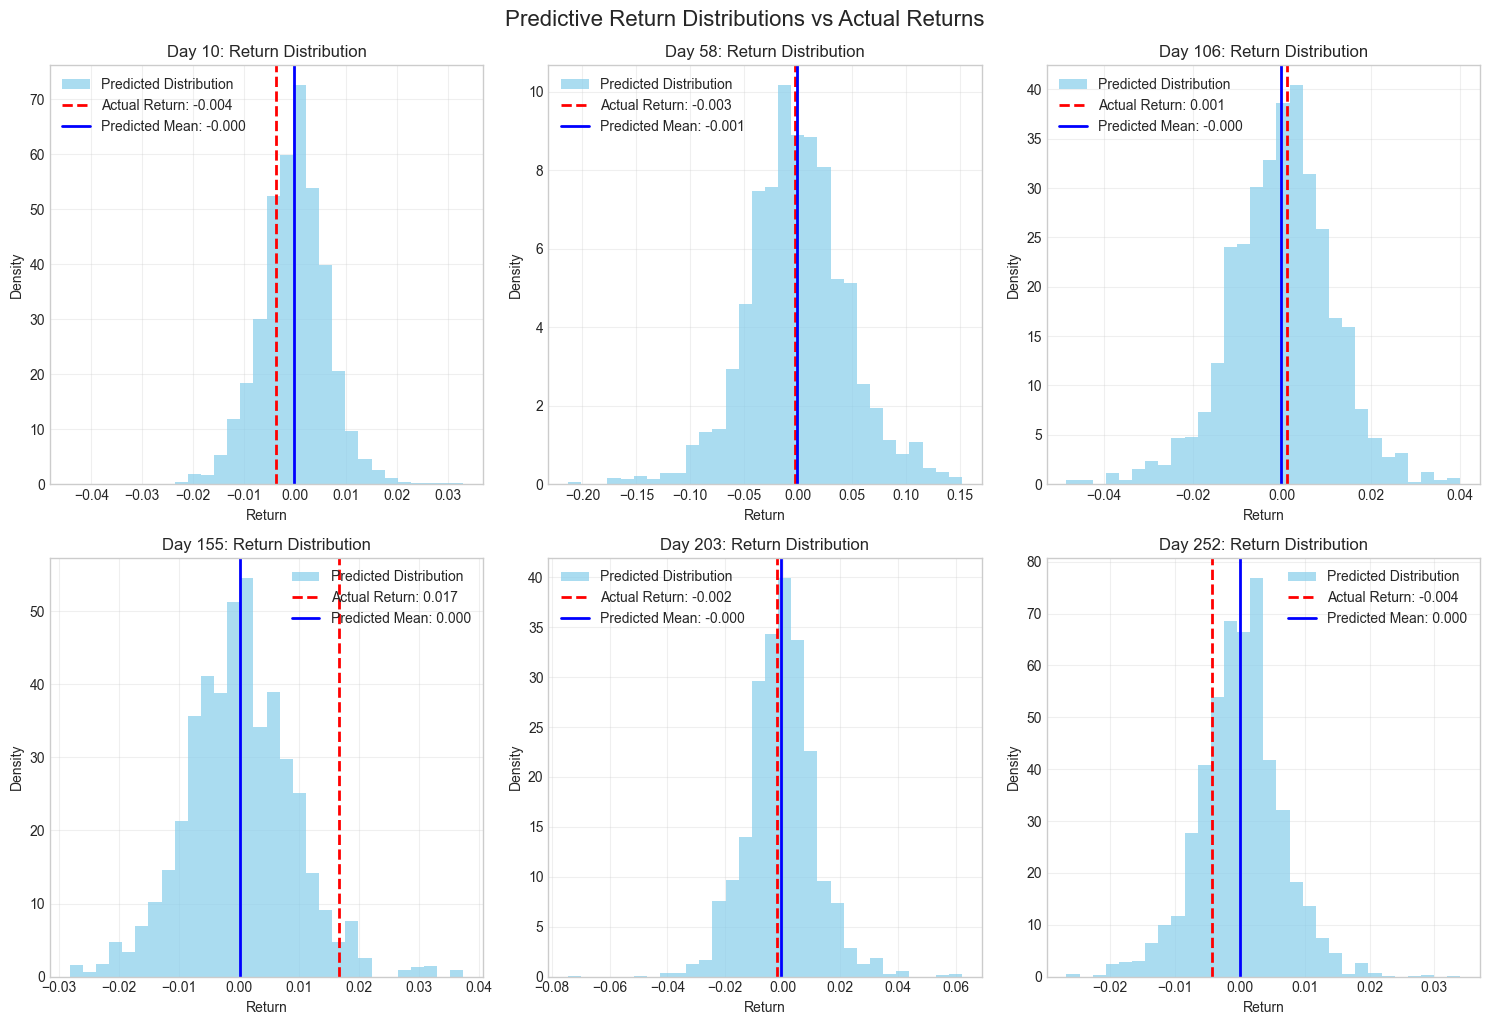

📊 Step 4: Creating return distribution visualizations...
1. Predictive distributions at selected time points:


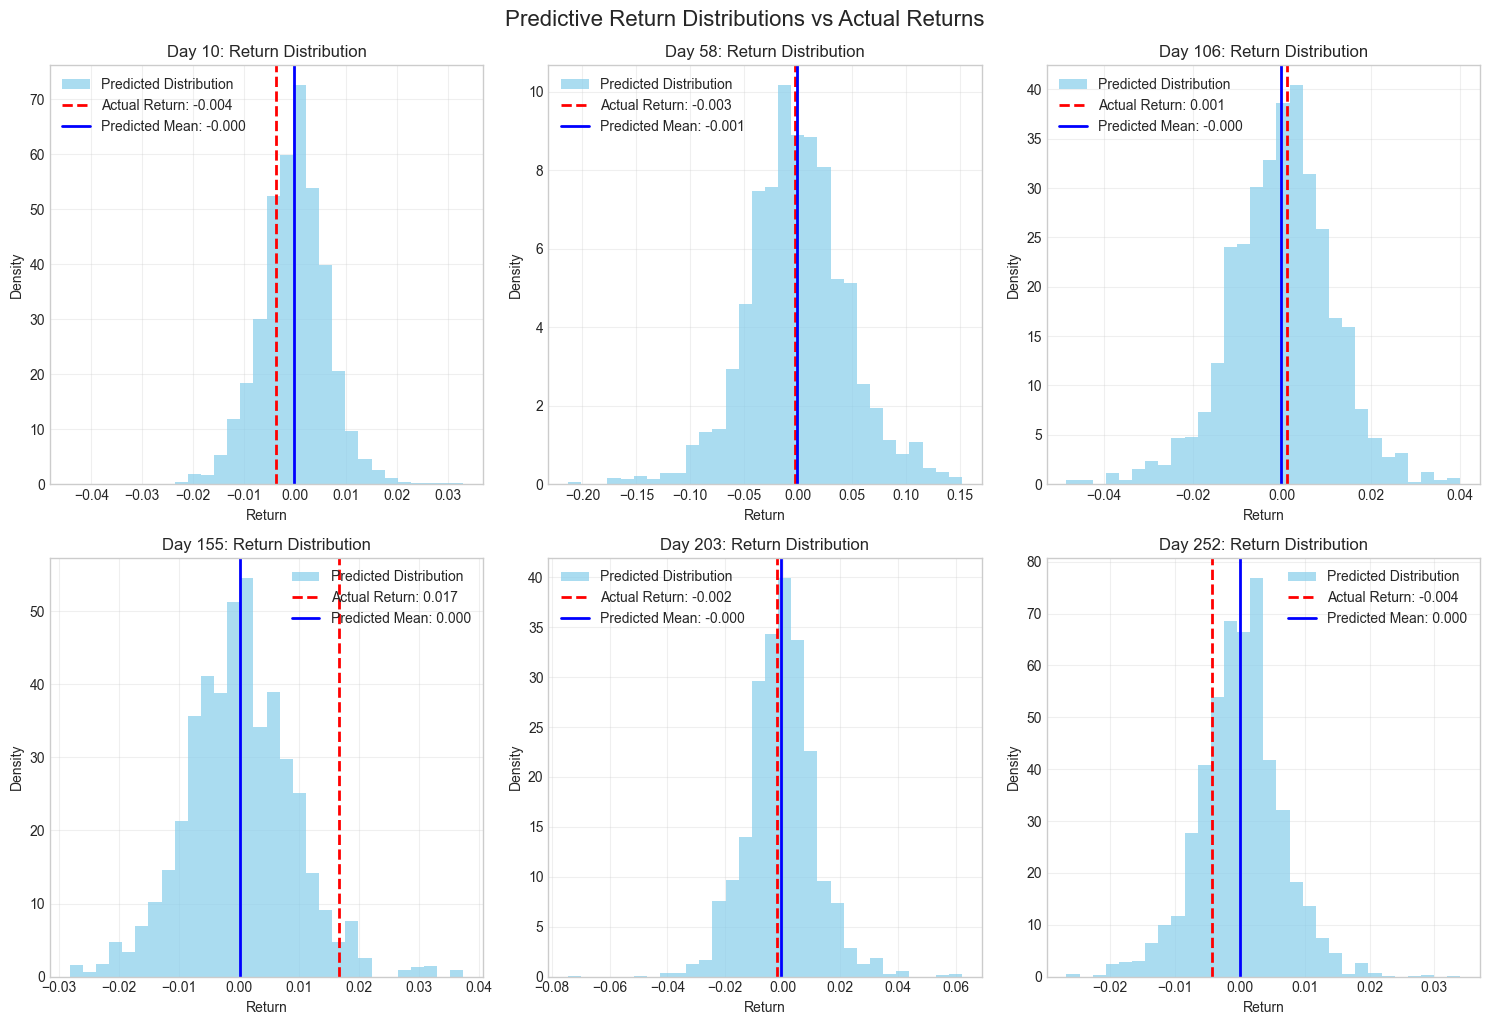

2. Prediction intervals and coverage:


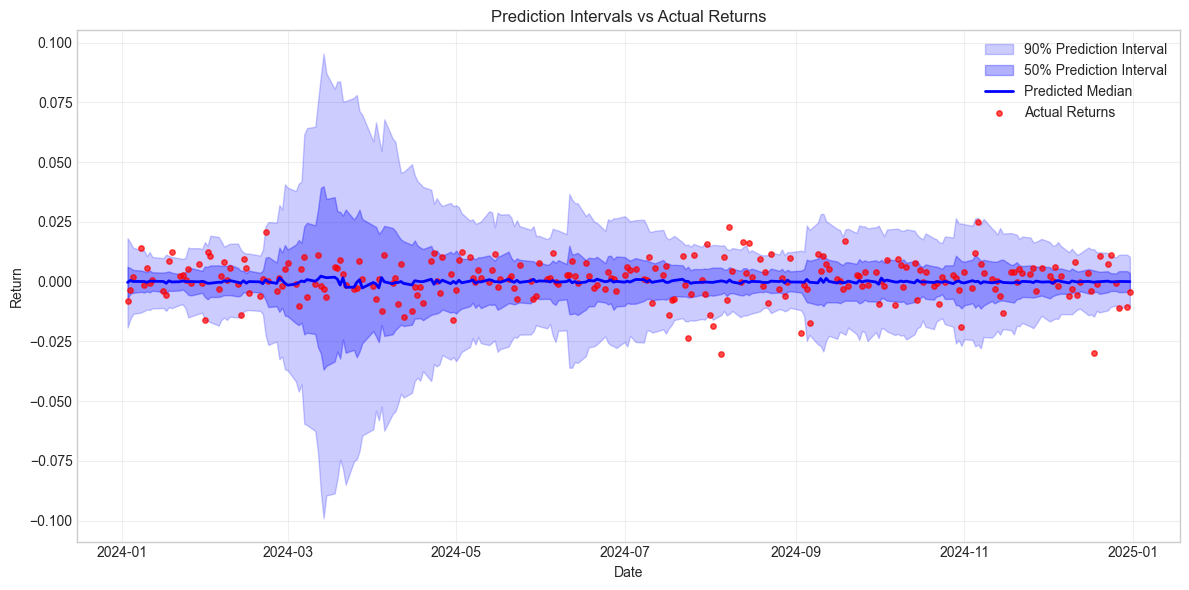

Prediction Interval Coverage:
  90% interval: 94.4% (target: 90%)
  50% interval: 72.9% (target: 50%)


In [20]:
# =============================================================================
# PREDICTIVE DISTRIBUTION VISUALIZATION FUNCTIONS
# =============================================================================

def plot_return_distributions(predictive_particles, actual_returns, n_examples=6):
    """
    Plot predictive return distributions vs actual returns for selected time points
    
    Parameters:
    -----------
    predictive_particles : list
        Predictive particles from SMC algorithm
    actual_returns : array
        Actual return values
    n_examples : int, default=6
        Number of time points to visualize
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Start from day 10 and select time points evenly spaced throughout the test period
    start_point = 9  # Day 10 (0-indexed)
    max_point = min(len(predictive_particles), len(actual_returns))-1
    time_points = np.linspace(start_point, max_point, n_examples, dtype=int)
    
    for i, t in enumerate(time_points):
        if t < len(predictive_particles) and t < len(actual_returns) and predictive_particles[t] is not None:
            # Get predictive particles for time t
            weights, particles = predictive_particles[t]
            
            # Plot predictive distribution
            axes[i].hist(particles, bins=30, density=True, alpha=0.7, 
                        label='Predicted Distribution', color='skyblue', weights=weights.W)
            
            # Add actual return as vertical line
            axes[i].axvline(actual_returns[t], color='red', linestyle='--', linewidth=2,
                           label=f'Actual Return: {actual_returns[t]:.3f}')
            
            # Add predicted mean
            pred_mean = np.average(particles, weights=weights.W)
            axes[i].axvline(pred_mean, color='blue', linestyle='-', linewidth=2,
                           label=f'Predicted Mean: {pred_mean:.3f}')
            
            axes[i].set_title(f'Day {t+1}: Return Distribution')
            axes[i].set_xlabel('Return')
            axes[i].set_ylabel('Density')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

def plot_quantile_analysis(predictive_particles, actual_returns, test_data_decimal):
    """
    Analyze prediction quality using quantiles
    
    Parameters:
    -----------
    predictive_particles : list
        Predictive particles from SMC algorithm
    actual_returns : array
        Actual return values
    test_data_decimal : pd.DataFrame
        Test data with dates
        
    Returns:
    --------
    tuple : Coverage statistics (90%, 50%)
    """
    n_points = min(len(predictive_particles), len(actual_returns))
    
    # Calculate prediction intervals
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    pred_quantiles = {q: [] for q in quantiles}
    
    for t in range(n_points):
        if predictive_particles[t] is not None:
            weights, particles = predictive_particles[t]
        else:
            continue
        # Calculate weighted quantiles
        sorted_idx = np.argsort(particles)
        sorted_particles = particles[sorted_idx]
        sorted_weights = weights.W[sorted_idx]
        cumsum_weights = np.cumsum(sorted_weights)
        
        for q in quantiles:
            # Find quantile
            idx = np.searchsorted(cumsum_weights, q)
            if idx < len(sorted_particles):
                pred_quantiles[q].append(sorted_particles[idx])
            else:
                pred_quantiles[q].append(sorted_particles[-1])
    
    # Plot quantile bands
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Only use dates where we have valid predictions
    valid_dates = []
    valid_actual_returns = []
    date_idx = 0
    for t in range(n_points):
        if predictive_particles[t] is not None:
            valid_dates.append(test_data_decimal.index[date_idx])
            valid_actual_returns.append(actual_returns[date_idx])
        date_idx += 1

    # Plot prediction intervals
    ax.fill_between(valid_dates, pred_quantiles[0.05], pred_quantiles[0.95], 
                    alpha=0.2, color='blue', label='90% Prediction Interval')
    ax.fill_between(valid_dates, pred_quantiles[0.25], pred_quantiles[0.75], 
                    alpha=0.3, color='blue', label='50% Prediction Interval')
    ax.plot(valid_dates, pred_quantiles[0.5], 'b-', linewidth=2, label='Predicted Median')

    # Plot actual returns
    ax.scatter(valid_dates, valid_actual_returns, color='red', alpha=0.7, s=15, label='Actual Returns')
    
    ax.set_title('Prediction Intervals vs Actual Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics
    coverage_90 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.05]) & 
                     (np.array(valid_actual_returns) <= pred_quantiles[0.95]))
    coverage_50 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.25]) & 
                     (np.array(valid_actual_returns) <= pred_quantiles[0.75]))
    
    print(f"Prediction Interval Coverage:")
    print(f"  90% interval: {coverage_90:.1%} (target: 90%)")
    print(f"  50% interval: {coverage_50:.1%} (target: 50%)")
    
    return coverage_90, coverage_50

# =============================================================================
# VISUALIZATION EXECUTION
# =============================================================================

print("📊 Step 4: Creating return distribution visualizations...")

# Extract data from online results
predictive_particles = online_results['smc_algo'].summaries.obs_predictive_particles
n_train = len(train_data_decimal)
actual_returns = pd.concat([train_data_decimal['Returns'], test_data_decimal['Returns']]).values[n_train:]

# 1. Distribution snapshots at different time points (starting from day 10)
print("1. Predictive distributions at selected time points:")
plot_return_distributions(predictive_particles, actual_returns)

# 2. Quantile-based analysis
print("2. Prediction intervals and coverage:")
coverage_stats = plot_quantile_analysis(predictive_particles, actual_returns, test_data_decimal)

In [21]:
# =============================================================================
# NEGATIVE LOG PREDICTIVE DENSITY (NLPD) CALCULATION FUNCTIONS
# =============================================================================

def calculate_sv_nlpd_with_estimated_params(mcmc_results, returns_train, returns_test, N=1000):
    """
    Calculate NLPD using estimated parameters from MCMC and the collector framework
    
    Parameters:
    -----------
    mcmc_results : dict
        Results from MCMC parameter estimation
    returns_train : pd.Series
        Training returns (not used in calculation but for consistency)
    returns_test : pd.Series
        Test returns for NLPD calculation
    N : int, default=1000
        Number of particles
        
    Returns:
    --------
    list : NLPD scores for each time point
    """
    # Get posterior mean estimates
    estimates = mcmc_results['estimates']
    mu_est = float(estimates['mu']['mean'])
    phi_est = float(estimates['phi']['mean'])
    sigma_x_est = float(estimates['sigma_x']['mean'])
    
    # Create model with estimated parameters
    # Convert phi back to logit_phi for the model
    logit_phi_est = np.log(phi_est / (1 - phi_est))
    estimated_model = StochasticVolatilityModel(
        mu=mu_est, 
        logit_phi=logit_phi_est, 
        sigma_x=sigma_x_est
    )
    
    # Create Feynman-Kac representation with test data
    fk = Bootstrap(ssm=estimated_model, data=returns_test)
    
    # Create NLPD collector
    nlpd_collector = NLPD(K=1)
    
    # Run SMC with collector
    smc = particles.SMC(fk=fk, N=N, collect=[nlpd_collector], ESSrmin=0.7)
    smc.run()
    
    # Extract NLPD scores
    nlpd_scores = smc.summaries.nlpd
    nlpd_scores = [score for score in nlpd_scores if score is not None]
    
    return nlpd_scores

def calculate_bs_nlpd_with_collector(train_returns, test_returns, N=1000):
    """
    Calculate NLPD for Black-Scholes using collector framework
    
    Parameters:
    -----------
    train_returns : pd.Series
        Training returns for volatility estimation
    test_returns : pd.Series
        Test returns for NLPD calculation
    N : int, default=1000
        Number of particles
        
    Returns:
    --------
    list : NLPD scores for each time point
    """
    # Estimate constant volatility from training data
    bs_volatility = train_returns.std()
    
    # Create simple constant volatility model
    bs_model = BlackScholesModel(volatility=bs_volatility)
    
    # Create Feynman-Kac representation
    fk = Bootstrap(ssm=bs_model, data=test_returns)
    
    # Create NLPD collector
    nlpd_collector = NLPD(K=1)
    
    # Run SMC with collector
    smc = particles.SMC(fk=fk, N=N, collect=[nlpd_collector])
    smc.run()
    
    # Extract NLPD scores
    nlpd_scores = smc.summaries.nlpd
    nlpd_scores = [score for score in nlpd_scores if score is not None]
    
    return nlpd_scores

In [ ]:
# =============================================================================
# NLPD ANALYSIS EXECUTION
# =============================================================================

print("📊 Step 5: Running NLPD analysis and model comparison...")

# Calculate NLPD for Black-Scholes baseline model
print("🎯 Calculating Black-Scholes NLPD scores...")
bs_nlpd_scores = calculate_bs_nlpd_with_collector(
    returns_train_decimal, 
    returns_test_decimal, 
    N=1000
)

# Calculate NLPD for Stochastic Volatility model with estimated parameters
print("🎯 Calculating Stochastic Volatility NLPD scores...")
sv_nlpd_scores = calculate_sv_nlpd_with_estimated_params(
    mcmc_results, 
    returns_train_decimal, 
    returns_test_decimal, 
    N=1000
)

print("✓ NLPD calculations completed")

📊 Step 4: Running NLPD analysis and model comparison...
🎯 Calculating Black-Scholes NLPD scores...
🎯 Calculating Stochastic Volatility NLPD scores...
✓ NLPD calculations completed
🎯 Calculating Stochastic Volatility NLPD scores...
✓ NLPD calculations completed


📊 Step 6: Creating NLPD comparison visualizations...
Debug: SV NLPD length = 251, type = <class 'list'>
Debug: BS NLPD length = 251, type = <class 'list'>
Debug: After cleaning - SV length = 251, BS length = 251
Debug: Final aligned lengths - SV = 251, BS = 251

📊 NLPD COMPARISON RESULTS:
Stochastic Volatility NLPD: -3.4032
Black-Scholes NLPD:        -3.1378
Improvement:                8.5%
Statistical significance:    p = 0.0000
✅ Stochastic Volatility model is BETTER (lower NLPD)


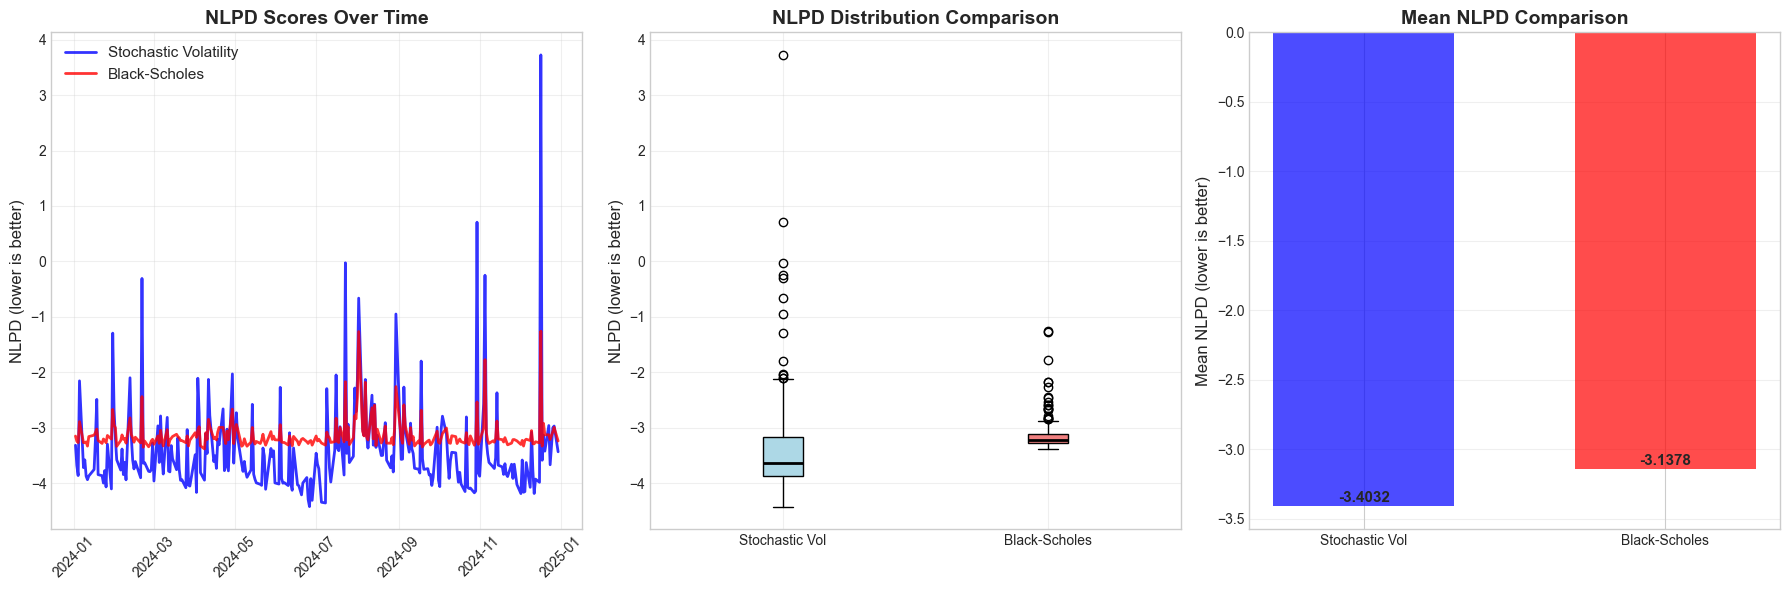


✅ NLPD analysis completed!
Results stored in 'nlpd_comparison' dictionary


In [22]:
# =============================================================================
# NLPD COMPARISON VISUALIZATION FUNCTIONS
# =============================================================================

def plot_nlpd_comparison(sv_nlpd_scores, bs_nlpd_scores, test_data_decimal):
    """
    Create comprehensive NLPD comparison plots
    
    Parameters:
    -----------
    sv_nlpd_scores : list
        NLPD scores for Stochastic Volatility model
    bs_nlpd_scores : list
        NLPD scores for Black-Scholes model
    test_data_decimal : pd.DataFrame
        Test data with dates
        
    Returns:
    --------
    dict : Comparison results and statistics
    """
    # Debug: Print lengths and types
    print(f"Debug: SV NLPD length = {len(sv_nlpd_scores)}, type = {type(sv_nlpd_scores)}")
    print(f"Debug: BS NLPD length = {len(bs_nlpd_scores)}, type = {type(bs_nlpd_scores)}")
    
    # Convert to numpy arrays and handle any nested structures
    sv_flat = np.array(sv_nlpd_scores).flatten()
    bs_flat = np.array(bs_nlpd_scores).flatten()
    
    # Remove any NaN or infinite values
    sv_clean = sv_flat[np.isfinite(sv_flat)]
    bs_clean = bs_flat[np.isfinite(bs_flat)]
    
    print(f"Debug: After cleaning - SV length = {len(sv_clean)}, BS length = {len(bs_clean)}")
    
    # Align to the same length
    min_length = min(len(sv_clean), len(bs_clean))
    sv_aligned = sv_clean[:min_length]
    bs_aligned = bs_clean[:min_length]
    
    print(f"Debug: Final aligned lengths - SV = {len(sv_aligned)}, BS = {len(bs_aligned)}")
    
    # Calculate means
    sv_mean = np.mean(sv_aligned)
    bs_mean = np.mean(bs_aligned)
    
    # Statistical test (only if we have enough data points)
    if len(sv_aligned) > 1 and len(bs_aligned) > 1:
        t_stat, p_value = stats.ttest_rel(bs_aligned, sv_aligned)
    else:
        t_stat, p_value = np.nan, np.nan
        print("Warning: Not enough data points for statistical test")
    
    # Print results
    improvement = (bs_mean - sv_mean) / abs(bs_mean) * 100 if bs_mean != 0 else 0
    print(f"\n📊 NLPD COMPARISON RESULTS:")
    print(f"=" * 40)
    print(f"Stochastic Volatility NLPD: {sv_mean:.4f}")
    print(f"Black-Scholes NLPD:        {bs_mean:.4f}")
    print(f"Improvement:                {improvement:.1f}%")
    if not np.isnan(p_value):
        print(f"Statistical significance:    p = {p_value:.4f}")
    
    if improvement > 0:
        print(f"✅ Stochastic Volatility model is BETTER (lower NLPD)")
    else:
        print(f"❌ Black-Scholes model is better (lower NLPD)")
    
    # Create the three plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: NLPD Scores Over Time
    dates = test_data_decimal.index[:min_length]
    axes[0].plot(dates, sv_aligned, 'b-', label='Stochastic Volatility', linewidth=2, alpha=0.8)
    axes[0].plot(dates, bs_aligned, 'r-', label='Black-Scholes', linewidth=2, alpha=0.8)
    axes[0].set_title('NLPD Scores Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('NLPD (lower is better)', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: NLPD Distribution Comparison (Box Plot)
    bp = axes[1].boxplot([sv_aligned, bs_aligned], 
                        labels=['Stochastic Vol', 'Black-Scholes'],
                        patch_artist=True,
                        medianprops={'color': 'black', 'linewidth': 2})
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[1].set_title('NLPD Distribution Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('NLPD (lower is better)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Mean NLPD Comparison (Bar Chart)
    models = ['Stochastic Vol', 'Black-Scholes']
    means = [sv_mean, bs_mean]
    colors = ['blue', 'red']
    
    bars = axes[2].bar(models, means, color=colors, alpha=0.7, width=0.6)
    axes[2].set_title('Mean NLPD Comparison', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Mean NLPD (lower is better)', fontsize=12)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, means):
        height = bar.get_height()
        y_offset = (max(means) - min(means)) * 0.02 if max(means) != min(means) else 0.01
        axes[2].text(bar.get_x() + bar.get_width()/2., height + y_offset,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return {
        'sv_nlpd': sv_aligned,
        'bs_nlpd': bs_aligned,
        'sv_mean': sv_mean,
        'bs_mean': bs_mean,
        'improvement': improvement,
        'p_value': p_value
    }

# =============================================================================
# NLPD COMPARISON EXECUTION
# =============================================================================

print("📊 Step 6: Creating NLPD comparison visualizations...")
nlpd_comparison = plot_nlpd_comparison(sv_nlpd_scores, bs_nlpd_scores, test_data_decimal)

print(f"\n✅ NLPD analysis completed!")
print(f"Results stored in 'nlpd_comparison' dictionary")

### Spikes analysis


📊 Step 7: Running NLPD spike analysis...
🔍 ANALYZING NLPD SPIKES (threshold = 2.0)
SV Model spikes above 2.0: 1 days
BS Model spikes above 2.0: 0 days
Either model spikes: 1 days

📅 SPIKE DATES AND DETAILS:
--------------------------------------------------------------------------------
2024-12-17 | Return:  -0.00% | SV NLPD:   3.73 | BS NLPD:  -1.26

🚨 TOP 5 WORST NLPD DAYS:
--------------------------------------------------
1. 2024-12-17 | Return:  -0.00% | Worst NLPD: 3.73 (SV)

📊 SPIKE ANALYSIS:
------------------------------
Days with |returns| > 2%: 0
Spikes on extreme return days: 0
% of spikes on extreme days: 0.0%


📊 Step 7: Running NLPD spike analysis...
🔍 ANALYZING NLPD SPIKES (threshold = 2.0)
SV Model spikes above 2.0: 1 days
BS Model spikes above 2.0: 0 days
Either model spikes: 1 days

📅 SPIKE DATES AND DETAILS:
--------------------------------------------------------------------------------
2024-12-17 | Return:  -0.00% | SV NLPD:   3.73 | BS NLPD:  -1.26

🚨 TOP 5 WORST NLPD DAYS:
--------------------------------------------------
1. 2024-12-17 | Return:  -0.00% | Worst NLPD: 3.73 (SV)

📊 SPIKE ANALYSIS:
------------------------------
Days with |returns| > 2%: 0
Spikes on extreme return days: 0
% of spikes on extreme days: 0.0%


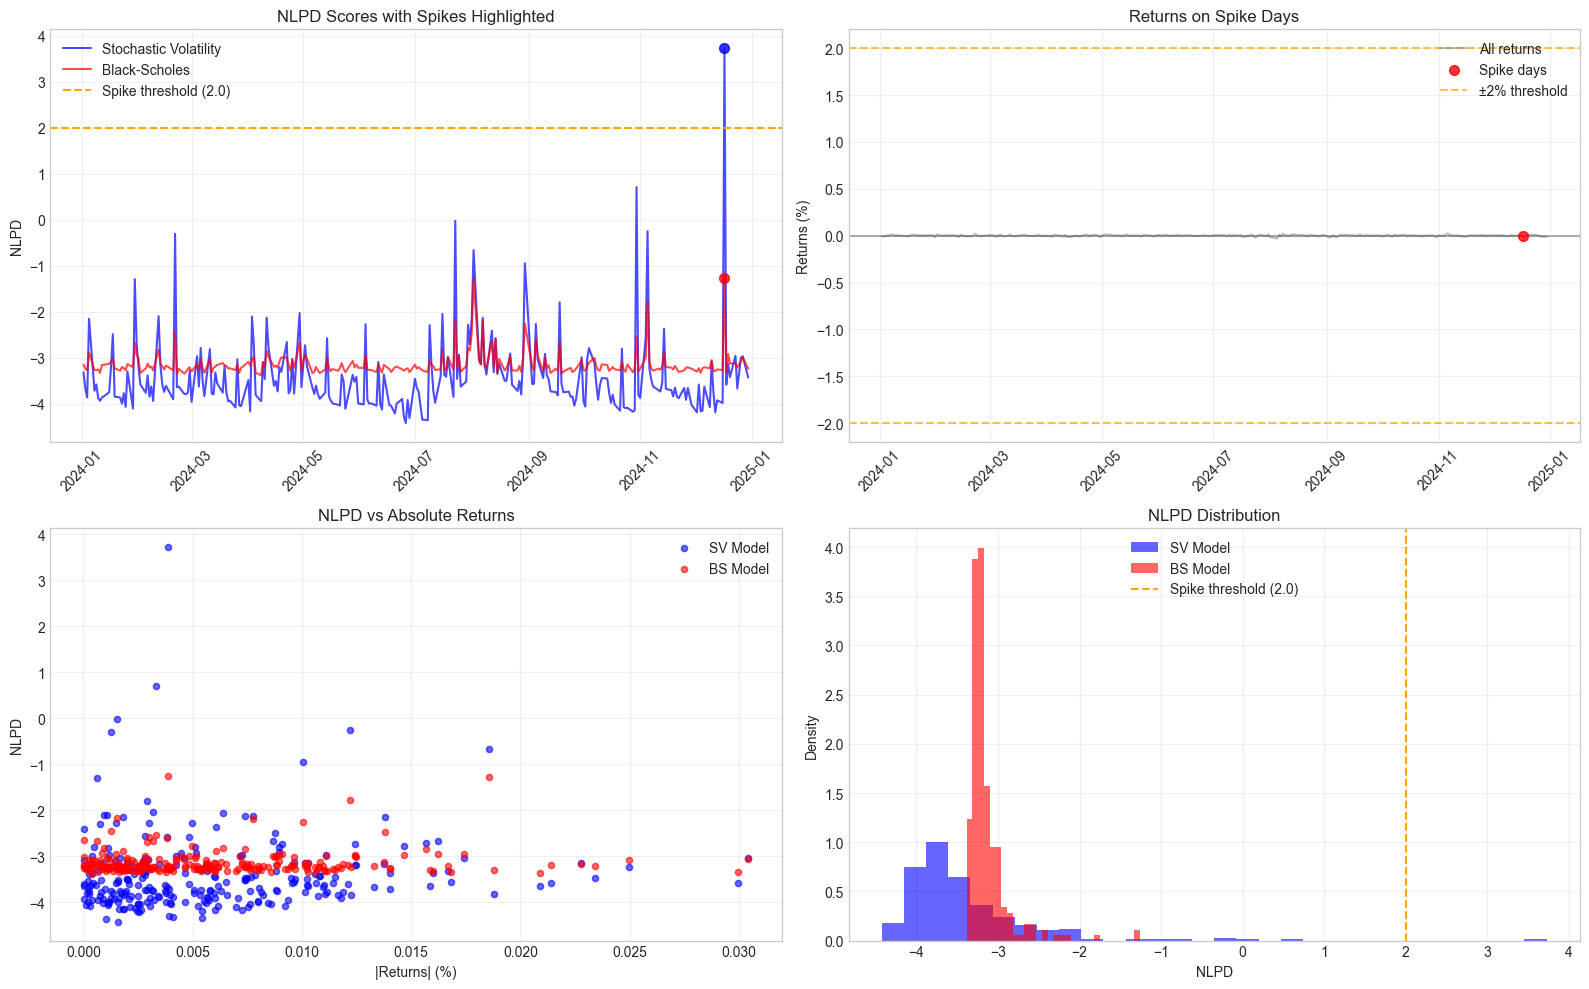

✅ Spike analysis completed


In [23]:
# =============================================================================
# NLPD SPIKE ANALYSIS FUNCTIONS
# =============================================================================

def analyze_nlpd_spikes(sv_nlpd_scores, bs_nlpd_scores, test_data_decimal, threshold=2.0):
    """
    Analyze NLPD spikes and identify problematic dates
    
    Parameters:
    -----------
    sv_nlpd_scores : list
        NLPD scores for Stochastic Volatility model
    bs_nlpd_scores : list
        NLPD scores for Black-Scholes model
    test_data_decimal : pd.DataFrame
        Test data with dates and returns
    threshold : float, default=2.0
        Threshold for identifying spikes
        
    Returns:
    --------
    list : Spike data information
    """
    # Align data
    min_length = min(len(sv_nlpd_scores), len(bs_nlpd_scores))
    sv_aligned = np.array(sv_nlpd_scores[:min_length]).flatten()
    bs_aligned = np.array(bs_nlpd_scores[:min_length]).flatten()
    dates = test_data_decimal.index[:min_length]
    returns = test_data_decimal['Returns'].values[:min_length]
    
    print(f"🔍 ANALYZING NLPD SPIKES (threshold = {threshold})")
    print("="*60)
    
    # Find spikes for both models
    sv_spikes = sv_aligned > threshold
    bs_spikes = bs_aligned > threshold
    any_spikes = sv_spikes | bs_spikes
    
    print(f"SV Model spikes above {threshold}: {np.sum(sv_spikes)} days")
    print(f"BS Model spikes above {threshold}: {np.sum(bs_spikes)} days")
    print(f"Either model spikes: {np.sum(any_spikes)} days")
    
    if np.sum(any_spikes) > 0:
        print(f"\n📅 SPIKE DATES AND DETAILS:")
        print("-"*80)
        
        spike_data = []
        # Use boolean indexing correctly
        spike_indices = np.where(any_spikes)[0]
        
        for idx in spike_indices:
            date = dates[idx]
            ret = float(returns[idx])  # Convert to scalar
            sv_nlpd = float(sv_aligned[idx])  # Convert to scalar
            bs_nlpd = float(bs_aligned[idx])  # Convert to scalar
            
            spike_info = {
                'date': date,
                'return': ret,
                'sv_nlpd': sv_nlpd,
                'bs_nlpd': bs_nlpd,
                'abs_return': abs(ret)
            }
            spike_data.append(spike_info)
            
            print(f"{date.strftime('%Y-%m-%d')} | Return: {ret:6.2f}% | "
                  f"SV NLPD: {sv_nlpd:6.2f} | BS NLPD: {bs_nlpd:6.2f}")
        
        # Sort by highest NLPD
        spike_data.sort(key=lambda x: max(x['sv_nlpd'], x['bs_nlpd']), reverse=True)
        
        print(f"\n🚨 TOP 5 WORST NLPD DAYS:")
        print("-"*50)
        for i, spike in enumerate(spike_data[:5]):
            worst_nlpd = max(spike['sv_nlpd'], spike['bs_nlpd'])
            worst_model = "SV" if spike['sv_nlpd'] > spike['bs_nlpd'] else "BS"
            print(f"{i+1}. {spike['date'].strftime('%Y-%m-%d')} | "
                  f"Return: {spike['return']:6.2f}% | "
                  f"Worst NLPD: {worst_nlpd:.2f} ({worst_model})")
        
        # Analyze correlation with extreme returns
        extreme_returns = np.abs(returns) > 2  # |returns| > 2%
        spike_on_extreme = any_spikes & extreme_returns
        
        print(f"\n📊 SPIKE ANALYSIS:")
        print("-"*30)
        print(f"Days with |returns| > 2%: {np.sum(extreme_returns)}")
        print(f"Spikes on extreme return days: {np.sum(spike_on_extreme)}")
        if np.sum(extreme_returns) > 0:
            print(f"% of extreme days with spikes: {np.sum(spike_on_extreme)/np.sum(extreme_returns)*100:.1f}%")
        if np.sum(any_spikes) > 0:
            print(f"% of spikes on extreme days: {np.sum(spike_on_extreme)/np.sum(any_spikes)*100:.1f}%")
    else:
        print(f"\n✅ No spikes found above threshold {threshold}")
        spike_data = []
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: NLPD time series with spike threshold
    axes[0,0].plot(dates, sv_aligned, 'b-', alpha=0.7, label='Stochastic Volatility')
    axes[0,0].plot(dates, bs_aligned, 'r-', alpha=0.7, label='Black-Scholes')
    axes[0,0].axhline(y=threshold, color='orange', linestyle='--', 
                     label=f'Spike threshold ({threshold})')
    
    if np.sum(any_spikes) > 0:
        spike_indices = np.where(any_spikes)[0]
        axes[0,0].scatter(dates[spike_indices], sv_aligned[spike_indices], 
                         color='blue', s=50, alpha=0.8, zorder=5)
        axes[0,0].scatter(dates[spike_indices], bs_aligned[spike_indices], 
                         color='red', s=50, alpha=0.8, zorder=5)
    
    axes[0,0].set_title('NLPD Scores with Spikes Highlighted')
    axes[0,0].set_ylabel('NLPD')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Returns on spike days
    axes[0,1].plot(dates, returns, 'gray', alpha=0.5, label='All returns')
    if np.sum(any_spikes) > 0:
        spike_indices = np.where(any_spikes)[0]
        axes[0,1].scatter(dates[spike_indices], returns[spike_indices], 
                         color='red', s=50, alpha=0.8, label='Spike days', zorder=5)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0,1].axhline(y=2, color='orange', linestyle='--', alpha=0.7, label='±2% threshold')
    axes[0,1].axhline(y=-2, color='orange', linestyle='--', alpha=0.7)
    axes[0,1].set_title('Returns on Spike Days')
    axes[0,1].set_ylabel('Returns (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot 3: NLPD vs absolute returns
    axes[1,0].scatter(np.abs(returns), sv_aligned, alpha=0.6, color='blue', label='SV Model', s=20)
    axes[1,0].scatter(np.abs(returns), bs_aligned, alpha=0.6, color='red', label='BS Model', s=20)
    axes[1,0].set_xlabel('|Returns| (%)')
    axes[1,0].set_ylabel('NLPD')
    axes[1,0].set_title('NLPD vs Absolute Returns')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Histogram of NLPD scores
    axes[1,1].hist(sv_aligned, bins=30, alpha=0.6, color='blue', label='SV Model', density=True)
    axes[1,1].hist(bs_aligned, bins=30, alpha=0.6, color='red', label='BS Model', density=True)
    axes[1,1].axvline(x=threshold, color='orange', linestyle='--', 
                     label=f'Spike threshold ({threshold})')
    axes[1,1].set_xlabel('NLPD')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('NLPD Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return spike_data

# =============================================================================
# SPIKE ANALYSIS EXECUTION
# =============================================================================

print("📊 Step 7: Running NLPD spike analysis...")
spike_analysis = analyze_nlpd_spikes(sv_nlpd_scores, bs_nlpd_scores, test_data_decimal, threshold=2.0)
print("✅ Spike analysis completed")